<a href="https://colab.research.google.com/github/sandyweng/Lung_Cancer_Deep_Learning/blob/main/Normal_vs_Aca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from keras import models
from keras import layers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout
from keras.models import Model, Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [ ]:
!unzip gdrive/My\ Drive/Aca_Normal.zip > /dev/null

In [ ]:
train_dir = '/content/Aca_Normal/train'
validation_dir = '/content/Aca_Normal/validation'
test_dir = '/content/Aca_Normal/test'

In [ ]:
conv_base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
   input_shape=(150,150,3)
)


58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
import numpy as np

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 6400)

Found 6400 images belonging to 2 classes.


In [ ]:
validation_features, validation_labels = extract_features(validation_dir, 1600)
test_features, test_labels = extract_features(test_dir, 2000)

Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
train_features = np.reshape(train_features, (6400, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1600, 4 * 4 * 512))

test_features = np.reshape(test_features, (2000, 4 * 4 * 512))

In [ ]:
# using feature extractions
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=50,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels), callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=8)])

Epoch 1/50
320/320 [==============================] - 19s 15ms/step - loss: 0.2240 - acc: 0.9024 - val_loss: 0.0425 - val_acc: 0.9912
Epoch 2/50
320/320 [==============================] - 4s 14ms/step - loss: 0.0358 - acc: 0.9898 - val_loss: 0.0318 - val_acc: 0.9919
Epoch 3/50
320/320 [==============================] - 4s 14ms/step - loss: 0.0210 - acc: 0.9950 - val_loss: 0.0188 - val_acc: 0.9950
Epoch 4/50
320/320 [==============================] - 4s 14ms/step - loss: 0.0107 - acc: 0.9986 - val_loss: 0.0161 - val_acc: 0.9956
Epoch 5/50
320/320 [==============================] - 4s 14ms/step - loss: 0.0073 - acc: 0.9997 - val_loss: 0.0126 - val_acc: 0.9962
Epoch 6/50
320/320 [==============================] - 4s 14ms/step - loss: 0.0051 - acc: 0.9999 - val_loss: 0.0149 - val_acc: 0.9956
Epoch 7/50
320/320 [==============================] - 4s 14ms/step - loss: 0.0046 - acc: 0.9996 - val_loss: 0.0109 - val_acc: 0.9969
Epoch 8/50
320/320 [==============================] - 4s 14ms/step -

In [ ]:
# with vgg base
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)

train_datagen = ImageDataGenerator(rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary', shuffle=False)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary', shuffle=False)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=5,
      validation_data=validation_generator)

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Epoch 1/5
5/5 [==============================] - 421s 92s/step - loss: 0.2697 - acc: 0.9047 - val_loss: 0.2116 - val_acc: 0.9069
Epoch 2/5
5/5 [==============================] - 373s 92s/step - loss: 0.0337 - acc: 1.0000 - val_loss: 0.1220 - val_acc: 0.9538
Epoch 3/5
5/5 [==============================] - 373s 92s/step - loss: 0.2996 - acc: 0.9333 - val_loss: 0.1562 - val_acc: 0.9356
Epoch 4/5
5/5 [==============================] - 373s 92s/step - loss: 0.0848 - acc: 0.9753 - val_loss: 0.0935 - val_acc: 0.9700
Epoch 5/5
5/5 [==============================] - 372s 92s/step - loss: 0.0414 - acc: 0.9946 - val_loss: 0.0903 - val_acc: 0.9700


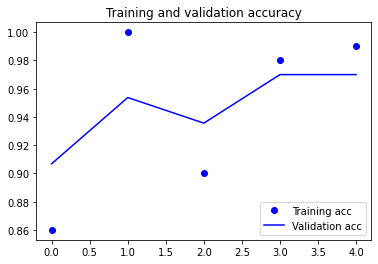

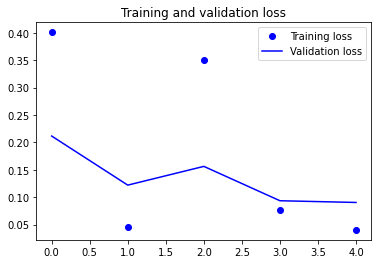

In [ ]:


import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary', shuffle=False)

test_loss, test_acc = model.evaluate(test_generator,steps=5)
print('test acc:', test_acc)

Found 2000 images belonging to 2 classes.
5/5 [==============================] - 22s 4s/step - loss: 0.0808 - acc: 0.9600
test acc: 0.9599999785423279


In [ ]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(validation_generator, test_generator.samples / test_generator.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[800   0]
 [800   0]]


In [ ]:
train_generator.class_indices

{'lung_aca': 0, 'lung_n': 1}

In [ ]:

# unfreezing layer in vgg
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=50,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=20)

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

In [ ]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(validation_generator, test_generator.samples / test_generator.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[800   0]
 [800   0]]
